# A/B testing

In [1]:
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy as np

%run src/data.py
from src.plot import *
from src.stats import *

%matplotlib inline
plt.style.use('ggplot')
plt.show()

## Outline

1. Set up the experiment
 - What is the goal?
 - What is the metric and how much of an increase is worth the change?
 - How much statistical power and level of significance do you need? Typically 80% and 0.05 are used respectively.
2. Set up a control group and test group by selecting users at random
3. Run the test -> Record the success rate for each group
4. Plot the distribution of the difference between the two samples
5. Measure the probability of getting the result of the test group and the confidence interval. Check to see if there is enough statistical power and that the level of significance is achieved.
6. Consider other tradeoffs and decide if the change should be launched

## Variables

* Sample size
* Baseline conversion rate
* Minimum detectable effect
* Desired statistical power
* Confidence level or level of significance

## Control Group (A) and Test Group (B)

In [2]:
# A is control; B is test
N_A = 1000
N_B = 1000

p_A = 0.10
p_B = 0.12

# 1. Run test

In [3]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

## The converted column indicates whether a user signed up for the premium service or not with a 1 or 0, respectively. The A group will be used for our control group and the B group will be our test group.

In [4]:
print(ab_data.shape) 
ab_data.head()

(2000, 2)


,converted,group
0,0,A
1,0,A
2,0,A
3,0,A
4,0,B


In [5]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(92, 127)

In [6]:
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(992, 1008)

In [7]:
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.09274193548387097, 0.1259920634920635)

In [8]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

ab_summary

,converted,total,rate
group,,,
A,92,992,0.092742
B,127,1008,0.125992


# 2. Compare the Two Groups

We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).

In [9]:
point = p_B * A_total

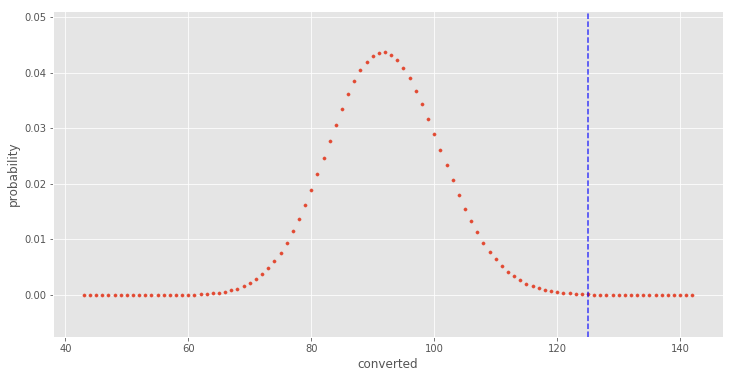

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, p_A).pmf(x)
ax.scatter(x, y, s=10)
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

In [11]:
x.shape, A_converted

((100,), 92)

### If we plot the binomial distribution that corresponds to the control group we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, we would get the following:

In [12]:
scs.binom(A_total, p_A).pmf(int(point))    # binom(n, p).pmf(p_B*A_total)

0.0001431121452350173

### That is a very low probability. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a 0.2% chance that we would have seen this result. Is this enough evidence of statistical significance? Let's get into statistical power.

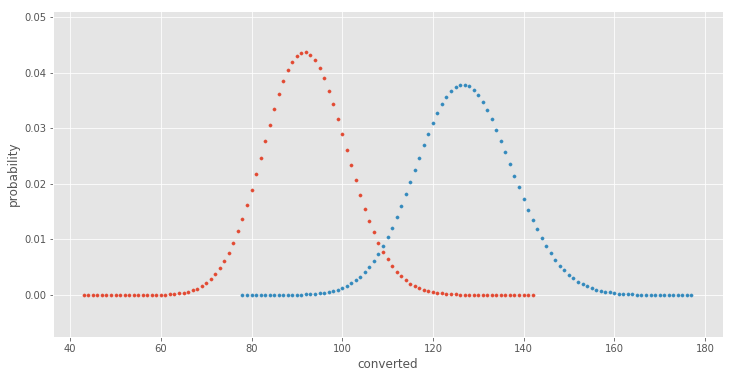

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('converted')
plt.ylabel('probability')

We can see that the test group converted more users than the control group. **However, the plot above is not a plot of the null and alternate hypothesis**. The **null hypothesis is a plot of the difference between the probability of the two groups.**

In order to calculate the difference between the two groups, we need to standardize the data. Because the number of samples might be different between the two groups, we should compare the probability of successes, p.

Consider the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) for the control group.

$$ X \sim Bernoulli(p) $$
where p is the true conversion probability of the control group.

According to the properties of the Bernoulli distribution, the mean and variance are as follows:

$$ E(X) = p $$

$$ Var(X) = p(1-p) $$ 

According to the central limit theorem, by calculating many sample means we can approximate the true mean of the population from which the data for the control group was taken. The distribution of the sample means will be normally distributed around the true mean with a standard deviation equal to the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

The [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error) is given as:

$$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}} $$

The same can be done with the alternate group.

Therefore, we can represent both groups as a normal distribution with the following properties

$$ \hat{p} \sim Normal\left(\mu = p, \: \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}\right) $$

In [14]:
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)   # standard error
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
SE_A, SE_B

(0.009209746157241419, 0.010451990745533483)

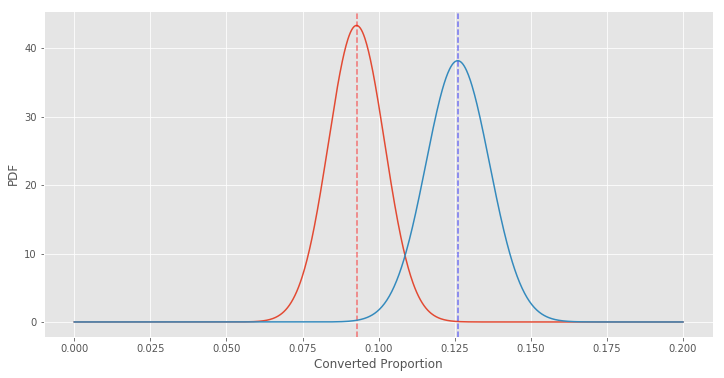

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

## Back to the Null and Alternate Hypothesis
Recall that the null hypothesis states that the difference in probability between the two groups is zero. We should construct a distribution of this difference, since for any A/B experiment our value for p each come from a two different distributions and the difference will have its own variance.
$$ H_0: d = 0 $$

$$ \hat{d} \sim Normal(0, \: SE_{pool}) $$

$$ H_A: d = p_B - p_A $$

$$ \hat{d} \sim Normal(d, \: SE_{pool}) $$

## Variance of the Sum
The [variance of the sum](https://en.wikipedia.org/wiki/Variance) (of two random independent variables) is the sum of the variances.

$$ Var(X + Y) = Var(X) + Var(Y) $$
$$ Var(X - Y) = Var(X) + Var(Y) $$

Because the distribution for the difference is calculated from two normal distributions, we can assume that the difference will be normally distributed.

The null hypothesis is the normal distribution of the difference with a mean of zero. 

The alternate hypothesis is the normal distribution of the difference with a mean of the difference in the means of the two groups. 

The null hypothesis and alternate hypothesis will the same variance which will be the sum of the variances for the control group and the test group.

$$ Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} $$

The standard deviation will be the square root of the variance.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} } $$

## Pooled Variance
We can put this equation in terms of $s$, where $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$

The is the [Satterthwaite approximation](http://www.statisticshowto.com/satterthwaite-approximation/) for pooled variance.

If we pool the probability like the [Udacity lesson](https://www.youtube.com/watch?v=iub8yWiO84I) and then calculate the variance for the pooled probability, we would end up with the same equation for pooled variance shown in the lesson.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_p^2}{n_A} + \frac{s_p^2}{n_B} } = \sqrt{ s_p \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } = \sqrt{ \hat{p}_p(1-\hat{p}_p) \left(\frac{1}{n_A} + \frac{1}{n_B} \right) } $$

$$ \hat{p}_p = \frac{p_A N_A + p_B N_B}{N_A + N_B} $$

# Statistical power
We now need to consider the confidence level of the test. We will plot the null hypothesis and the alternative hypothesis.

* The null hypothesis is that the change made for the test group **would result in no change** in the conversion rate.
* The alternative hypothesis is that the change for the test group **would result in a detectable change** in the conversion rate.

We can represent the null hypothesis by plotting the distribution of the difference between the control and test group. According to the Udacity course, the distribution will be normal with a mean of zero and a standard deviation equal to the pooled standard error. This is an application of the central limit theorem. 

According to statistics howto:

<font color='red'>**The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution.**</font>


**We can prove this by the following**: 
Our control and test groups are samples taken from a population. 
We are taking the mean of each group's distribution, which in this case is binomial, and we are finding the difference Let's demonstrate if this distribution is truly normal. We can use our data generation script to repeat this process 1000 times. We will set the variable, `d_hat`, to zero to represent the case where the null hypothesis is true.

### Pooled Standard Error

$$ SE_p = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$ 

$$ SE_p = S_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}} = \sqrt{S_p^2\left(\frac{1}{n_1} + \frac{1}{n_2} \right)} = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

$$ SE_p = \sqrt{ p_p(1-p_p) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)} $$

In [16]:
bcr = p_A               # baseline conversion rate
d_hat = p_B - p_A       # difference between the groups
N_A, N_B, bcr, d_hat

(1000, 1000, 0.09274193548387097, 0.03325012800819252)

# 3. Statistical Power and Significance Level
# Power = probability of not making type 2 error 
$$\textbf{power}=1-\beta$$

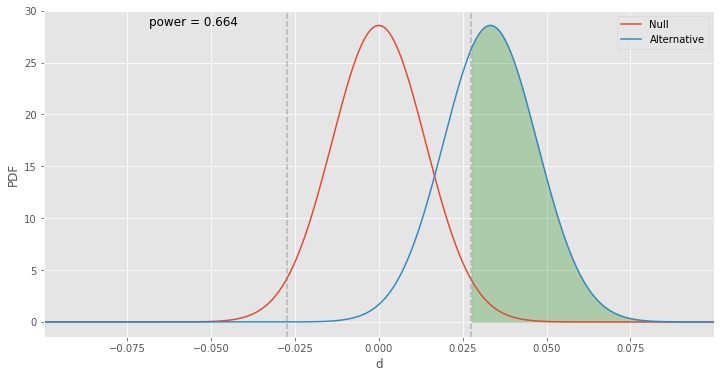

In [17]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

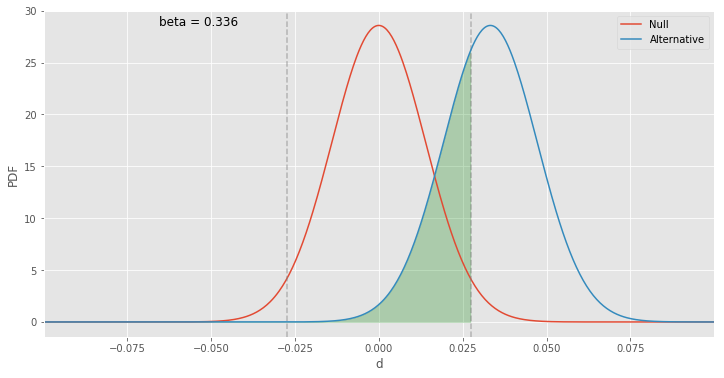

In [18]:
abplot(N_A, N_B, bcr, d_hat, show_beta=True)

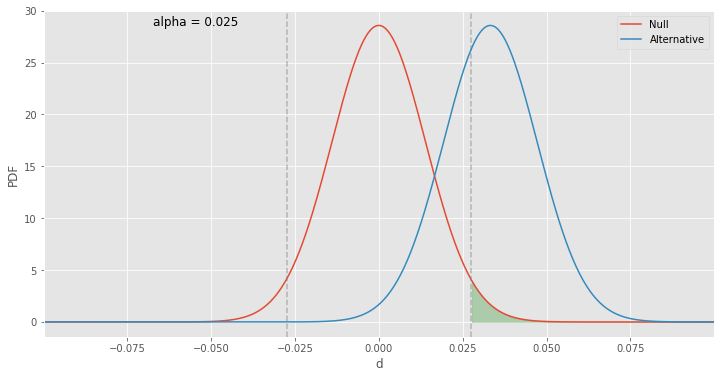

In [19]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

$$ \alpha = 100\% - \text{Confidence Level} $$

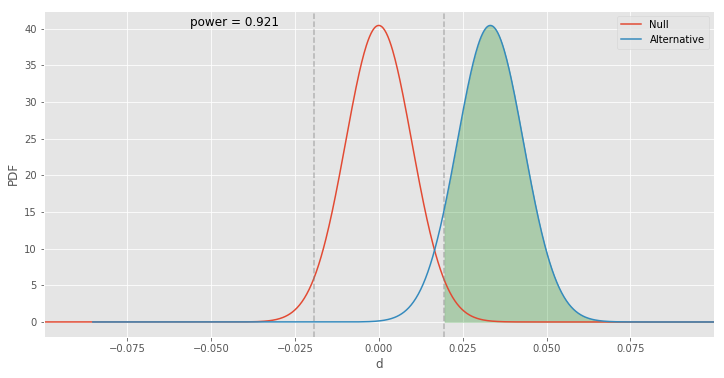

In [20]:
abplot(2000, 2000, bcr, d_hat, show_power=True)

# 4. Sample Size
## Calculate the minimum sample size

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_\beta + Z_{\alpha/2})^2}{(p_B - p_A)^2} $$

$$ Z_\beta : \text{z-score that corresponds to the level of statistical power} $$
$$ Z_{\alpha/2} : \text{z-score that corresponds to the level of significance or confidence level} $$

$$\bar{p}: \text{pooled probability or average of } p_A \text{ and } p_B $$
$$p_A: \text{success rate of control group} $$
$$p_B: \text{success rate of test group} $$

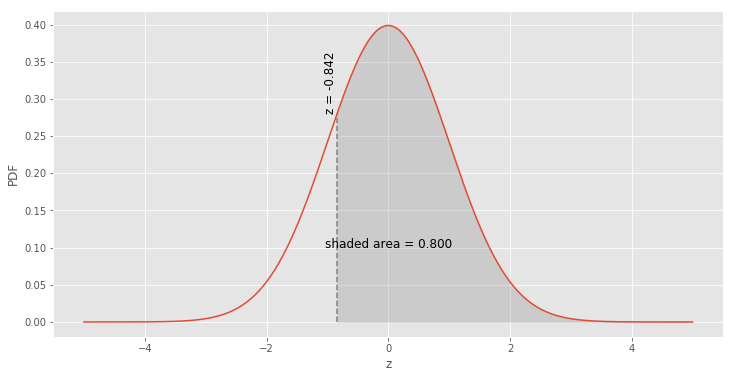

In [21]:
zplot(area=0.80, two_tailed=False, align_right=True)

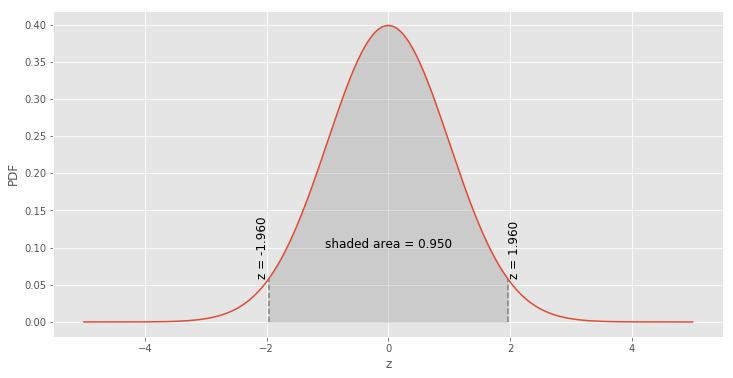

In [22]:
zplot(area=0.95, two_tailed=True)

3842.026629963879


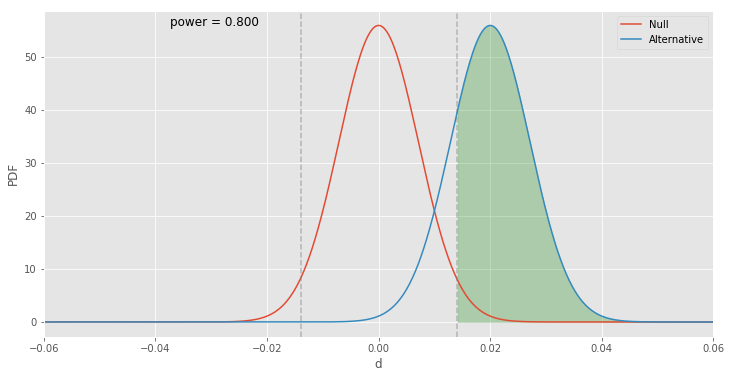

In [23]:
sample_size = min_sample_size(bcr=0.10, mde=0.02)
print(sample_size)
abplot(sample_size, sample_size, 0.10, 0.02, show_power=True)

# Increase the Sample Size

In [24]:
# parameters for generate_data()
N_A = 6000
N_B = 6000
p_A=0.10
p_B=0.12

In [25]:
ab_data = generate_data(N_A, N_B, p_A, p_B)

ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

ab_summary

,converted,total,rate
group,,,
A,612,5868,0.104294
B,788,6132,0.128506


In [26]:
# parameters for abplot
n = N_A + N_B
p_A_actual = ab_summary.loc['A', 'rate']
p_B_actual = ab_summary.loc['B', 'rate']
bcr = p_A_actual
d_hat = p_B_actual - p_A_actual

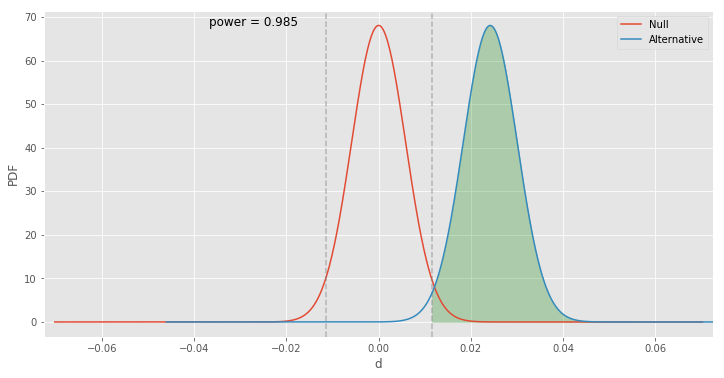

In [27]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

# Multiple Tests and Funnel Tests
## Confidence Interval Plot

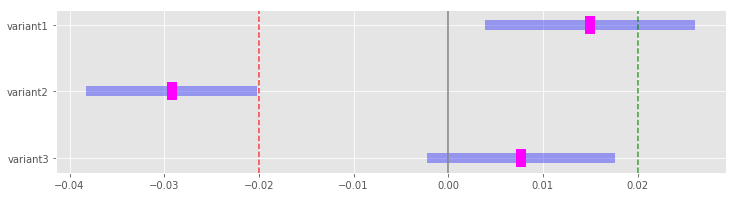

In [28]:
abplot_CI_bars((6000, 6000, 8900, 9100), (600, 690, 630, 980), sig_level=0.05, dmin=0.02)